In [3]:
import pandas as pd
import json
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from networkx.algorithms import approximation as approx
from networkx.algorithms.approximation.clustering_coefficient import average_clustering
import powerlaw
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.cuts import conductance
from collections import Counter

# ─── Part 1: Global Graph Metrics ───

In [4]:
# Step 1: Load & clean CSV
df = pd.read_csv('data.csv', sep=',(?=\S)', engine='python')

def delete_quotes(x):
    return x[1:-1] if isinstance(x, str) and len(x) > 1 else x

for col in ["id", "screenName", "avatar", "lang", "tweetId"]:
    df[col] = df[col].apply(delete_quotes)

df["friends"] = df["friends"].apply(lambda x: json.loads(x) if pd.notna(x) else [])

# Step 2: Build directed graph
G = nx.DiGraph()
root_users = set(df['id'].astype(str))
for _, row in df.iterrows():
    u = str(row['id'])
    G.add_node(u)
    for f in row['friends']:
        f = str(f)
        if f in root_users:
            G.add_edge(u, f)

# Step 3: Undirected version & connected components
G_und = G.to_undirected()
comps = list(nx.connected_components(G_und))
num_components = len(comps)
lcc_nodes = max(comps, key=len)
LCC = G_und.subgraph(lcc_nodes).copy()

# Step 4: Approximate diameter (2-sweep) on the LCC
diameter = approx.diameter(LCC, seed=42)

# Step 5: Approximate avg. local clustering (Monte Carlo) on full graph
approx_avg_clust = average_clustering(G_und, trials=1000, seed=42)

# Step 6: Approximate avg. shortest-path length on the LCC via sampling
k = min(100, len(lcc_nodes))
random.seed(42)
sources = random.sample(list(lcc_nodes), k)
total_d, total_pairs = 0, 0
for s in sources:
    dist = nx.single_source_shortest_path_length(LCC, s)
    total_d += sum(dist.values())
    total_pairs += (len(dist) - 1)
approx_avg_path = total_d / total_pairs

# Print Part 1 results
print("\n=== Part 1: Global Network Metrics ===")
print(f"{'Metric':<35} Value")
print(f"{'-'*50}")
print(f"{'Connected components':<35} {num_components}")
print(f"{'Approx. diameter (LCC)':<35} {diameter}")
print(f"{'Approx. avg. path length (LCC)':<35} {approx_avg_path:.4f}")
print(f"{'Approx. avg. clustering coef.':<35} {approx_avg_clust:.4f}")

KeyboardInterrupt: 

# ─── Part 2: Centrality Distributions ───

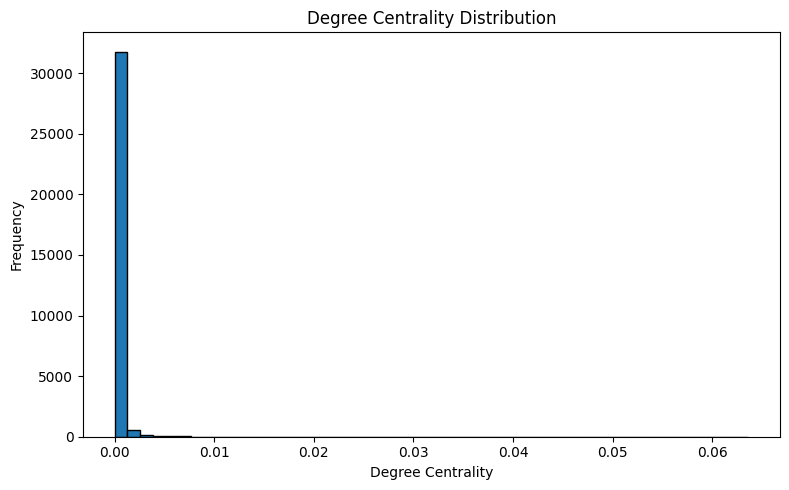

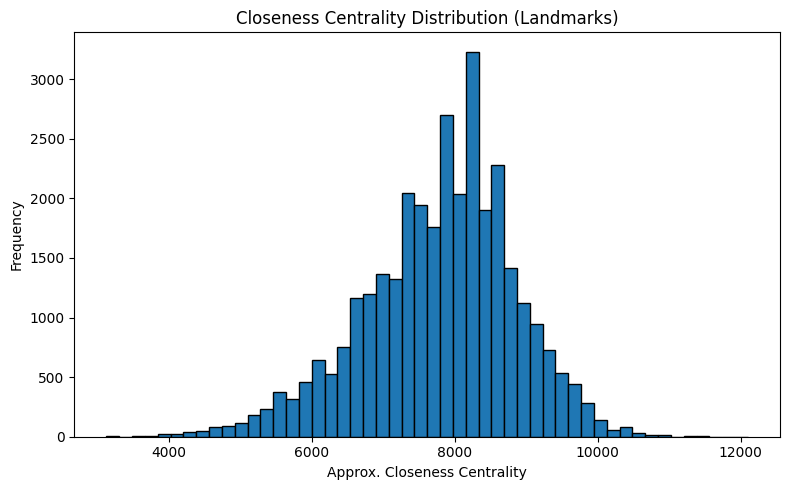

In [ ]:
# 2a. Exact degree centrality on the LCC
n = LCC.number_of_nodes()
deg_vals = [deg / (n - 1) for _, deg in LCC.degree()]

# 2b. Landmark-based approximate closeness centrality on the LCC
def approx_closeness_landmarks(G, k=30, seed=42):
    random.seed(seed)
    landmarks = random.sample(list(G.nodes()), k)
    dist_sum = {v: 0 for v in G.nodes()}
    for lm in landmarks:
        lengths = nx.single_source_shortest_path_length(G, lm)
        for v, d in lengths.items():
            dist_sum[v] += d
    N = G.number_of_nodes()
    closeness = {}
    for v, total in dist_sum.items():
        closeness[v] = (N - 1) * (k / total) if total > 0 else 0.0
    return closeness

cl_dict = approx_closeness_landmarks(LCC, k=30, seed=42)
close_vals = list(cl_dict.values())

# Plot Part 2
plt.figure(figsize=(8,5))
plt.hist(deg_vals, bins=50, edgecolor='black')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Degree Centrality Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(close_vals, bins=50, edgecolor='black')
plt.xlabel('Approx. Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Closeness Centrality Distribution (Landmarks)')
plt.tight_layout()
plt.show()

# ─── Part 3: Power-Law Fit with 90% CI ───

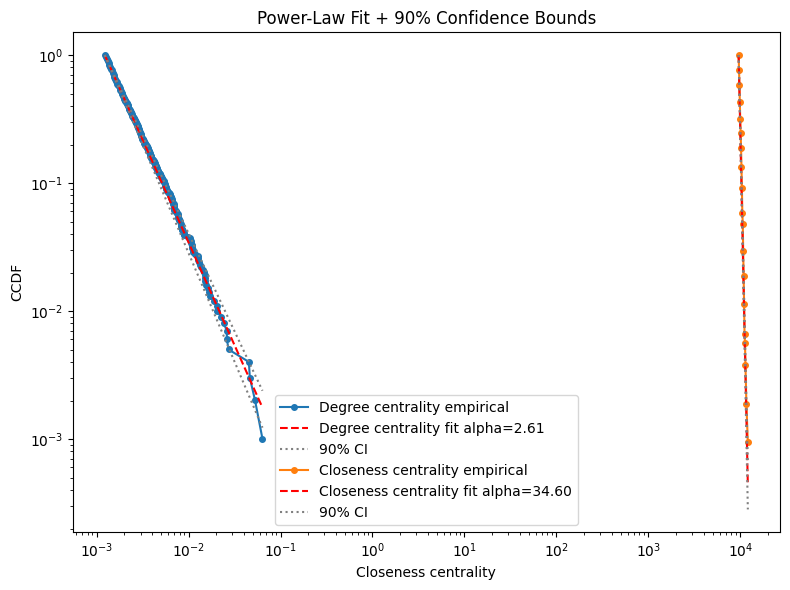


=== Part 3: Power-Law Exponents & 90% CI ===
Degree centrality:    alpha = 2.61, 90% CI = [2.53, 2.70]
Closeness centrality: alpha = 34.60, 90% CI = [32.89, 36.45]


In [ ]:
def plot_powerlaw_ci(data, label, ax, bs=200, seed=42):
    np.random.seed(seed)
    fit = powerlaw.Fit(data, discrete=False, verbose=False)
    alpha = fit.power_law.alpha
    x_min = fit.power_law.xmin

    filtered = np.array([x for x in data if x >= x_min])
    n = len(filtered)
    alpha_samples = []
    for _ in range(bs):
        samp = np.random.choice(filtered, size=n, replace=True)
        alpha_samples.append(1 + n / np.sum(np.log(samp / x_min)))
    alpha_low, alpha_up = np.percentile(alpha_samples, [5, 95])

    fit.plot_ccdf(ax=ax, label=f"{label} empirical", marker='o', markersize=4)
    xs = np.linspace(x_min, max(data), 200)
    emp_x, emp_ccdf = fit.ccdf()
    emp0 = next(y for x, y in zip(emp_x, emp_ccdf) if x >= x_min)

    ccdf_hat = emp0 * (xs / x_min) ** (-(alpha - 1))
    ccdf_low = emp0 * (xs / x_min) ** (-(alpha_low - 1))
    ccdf_up  = emp0 * (xs / x_min) ** (-(alpha_up  - 1))

    ax.plot(xs, ccdf_hat, color='r', linestyle='--', label=f"{label} fit alpha={alpha:.2f}")
    ax.plot(xs, ccdf_low, color='gray', linestyle=':', label="90% CI")
    ax.plot(xs, ccdf_up,  color='gray', linestyle=':')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel('CCDF')
    ax.legend()
    return alpha, alpha_low, alpha_up

fig, ax = plt.subplots(figsize=(8,6))
alpha_deg, alpha_deg_low, alpha_deg_high = plot_powerlaw_ci(deg_vals,   'Degree centrality',    ax)
alpha_clo, alpha_clo_low, alpha_clo_high = plot_powerlaw_ci(close_vals, 'Closeness centrality', ax)
plt.title('Power-Law Fit + 90% Confidence Bounds')
plt.tight_layout()
plt.show()

print("\n=== Part 3: Power-Law Exponents & 90% CI ===")
print(f"Degree centrality:    alpha = {alpha_deg:.2f}, 90% CI = [{alpha_deg_low:.2f}, {alpha_deg_high:.2f}]")
print(f"Closeness centrality: alpha = {alpha_clo:.2f}, 90% CI = [{alpha_clo_low:.2f}, {alpha_clo_high:.2f}]")

# ─── Part 4: Structural Equivalence by Degree Centrality ───

In [ ]:
max_bucket = 500      # only keep at most 500 nodes per degree
max_pairs   = 20000   # sample at most 20 000 pairs per bucket

degree_to_nodes = {}
for node, deg in LCC.degree():
    degree_to_nodes.setdefault(deg, []).append(node)

print("\n=== Part 4: Structural Equivalence by Degree (approx) ===")
print(f"{'Degree':<8}{'#Nodes':<8}{'#Pairs':<8}{'Avg Jaccard'}")
print("-"*40)

for deg, nodes in sorted(degree_to_nodes.items()):
    n = len(nodes)
    if n < 2:
        continue

    # 1) optionally down‐sample the bucket
    if n > max_bucket:
        nodes = random.sample(nodes, max_bucket)
        n = max_bucket

    # 2) generate or sample pairs
    total_possible = n*(n-1)//2
    if total_possible > max_pairs:
        pairs = random.sample(list(itertools.combinations(nodes,2)), max_pairs)
    else:
        pairs = list(itertools.combinations(nodes,2))

    # 3) compute Jaccard on those pairs
    sims = []
    for u, v, p in nx.jaccard_coefficient(LCC, pairs):
        sims.append(p)

    avg_sim = sum(sims) / len(sims)
    print(f"{deg:<8}{n:<8}{len(pairs):<8}{avg_sim:.4f}")


=== Part 4: Structural Equivalence by Degree (approx) ===
Degree  #Nodes  #Pairs  Avg Jaccard
----------------------------------------
1       500     20000   0.0022
2       500     20000   0.0030
3       500     20000   0.0037
4       500     20000   0.0030
5       500     20000   0.0036
6       500     20000   0.0037
7       500     20000   0.0041
8       500     20000   0.0044
9       500     20000   0.0050
10      500     20000   0.0058
11      500     20000   0.0044
12      426     20000   0.0047
13      369     20000   0.0042
14      316     20000   0.0050
15      307     20000   0.0058
16      239     20000   0.0051
17      219     20000   0.0045
18      217     20000   0.0043
19      165     13530   0.0046
20      164     13366   0.0043
21      159     12561   0.0049
22      134     8911    0.0049
23      125     7750    0.0045
24      103     5253    0.0051
25      90      4005    0.0053
26      92      4186    0.0036
27      86      3655    0.0069
28      87      3741    0.0

# ─── Part 5: Transitivity Scores ───

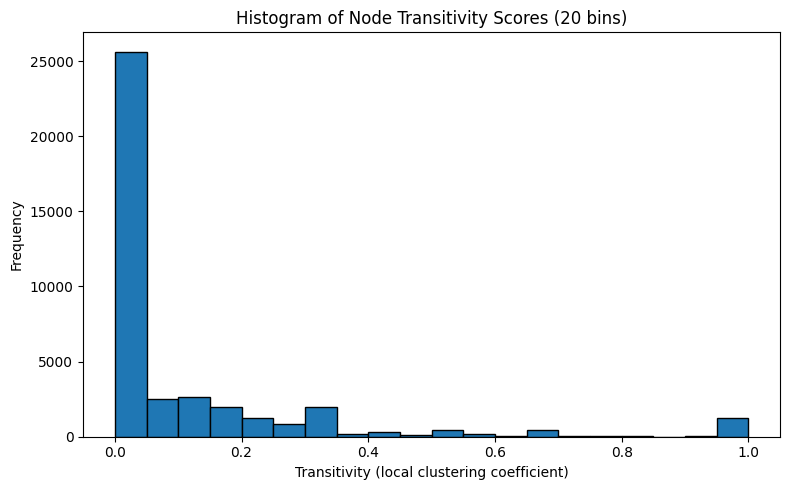

In [ ]:
# 1. Compute node‐level transitivity (local clustering)
trans_scores = nx.clustering(G_und)   # returns {node: c_i}

# 2. Extract the values
values = list(trans_scores.values())

# 3. Plot 20-bin histogram
plt.figure(figsize=(8,5))
plt.hist(values, bins=20, edgecolor='black')
plt.xlabel('Transitivity (local clustering coefficient)')
plt.ylabel('Frequency')
plt.title('Histogram of Node Transitivity Scores (20 bins)')
plt.tight_layout()
plt.show()

# ─── Part 6: Geodesic distance ───

In [ ]:
# 1) Node‐level transitivity on LCC only
trans_scores = nx.clustering(LCC)  # dict: node→clustering, only for LCC nodes

# 2) Prepare bins
NUM_BINS = 20
SAMPLE_K = 20
bin_edges = np.linspace(0.0, 1.0, NUM_BINS+1)

# 3) Assign & group nodes
bins = {i: [] for i in range(NUM_BINS)}
for node, score in trans_scores.items():
    b = np.digitize(score, bin_edges, right=False) - 1
    b = max(0, min(NUM_BINS-1, b))
    bins[b].append(node)

# 4) Compute avg geodesic per bin
results = []
for b, members in bins.items():
    if not members:
        continue
    sample_nodes = random.sample(members, min(len(members), SAMPLE_K))
    avg_dists = []
    for u in sample_nodes:
        lengths = nx.single_source_shortest_path_length(LCC, u)
        total = sum(lengths.values()) - 0
        count = len(lengths) - 1
        if count > 0:
            avg_dists.append(total / count)
    if not avg_dists:
        continue
    results.append({
        'bin': b,
        'range': f"[{bin_edges[b]:.2f}, {bin_edges[b+1]:.2f})",
        'n_in_bin': len(members),
        'avg_geodesic': sum(avg_dists) / len(avg_dists)
    })

# 5) Show one summary table
df_summary = pd.DataFrame(results)
print(df_summary)

    bin         range  n_in_bin  avg_geodesic
0     0  [0.00, 0.05)     18488      4.562583
1     1  [0.05, 0.10)      2515      3.947044
2     2  [0.10, 0.15)      2606      3.932227
3     3  [0.15, 0.20)      1976      4.083259
4     4  [0.20, 0.25)      1240      4.151037
5     5  [0.25, 0.30)       865      4.041742
6     6  [0.30, 0.35)      1993      4.296334
7     7  [0.35, 0.40)       199      4.064909
8     8  [0.40, 0.45)       316      4.176626
9     9  [0.45, 0.50)       131      4.387311
10   10  [0.50, 0.55)       435      4.571198
11   11  [0.55, 0.60)       149      4.271785
12   12  [0.60, 0.65)        47      4.205516
13   13  [0.65, 0.70)       436      4.638344
14   14  [0.70, 0.75)        20      4.440067
15   15  [0.75, 0.80)        22      4.288036
16   16  [0.80, 0.85)        70      4.872898
17   17  [0.85, 0.90)         9      5.005508
18   18  [0.90, 0.95)        13      5.197938
19   19  [0.95, 1.00)      1149      4.960328


# ─── Part 7: Fast Communities + Coarse Layout ───

Detected 2002 communities
Global modularity: 0.5001
Top 10 communities (size & phi):
  C 0 size=18136  phi=0.1185
  C 1 size= 5867  phi=0.0896
  C 2 size=  533  phi=0.2033
  C 3 size=  448  phi=0.3075
  C 4 size=  248  phi=0.1180
  C 5 size=  227  phi=0.3859
  C 6 size=  180  phi=0.3168
  C 7 size=   87  phi=0.2554
  C 8 size=   83  phi=0.2159
  C 9 size=   77  phi=0.4518


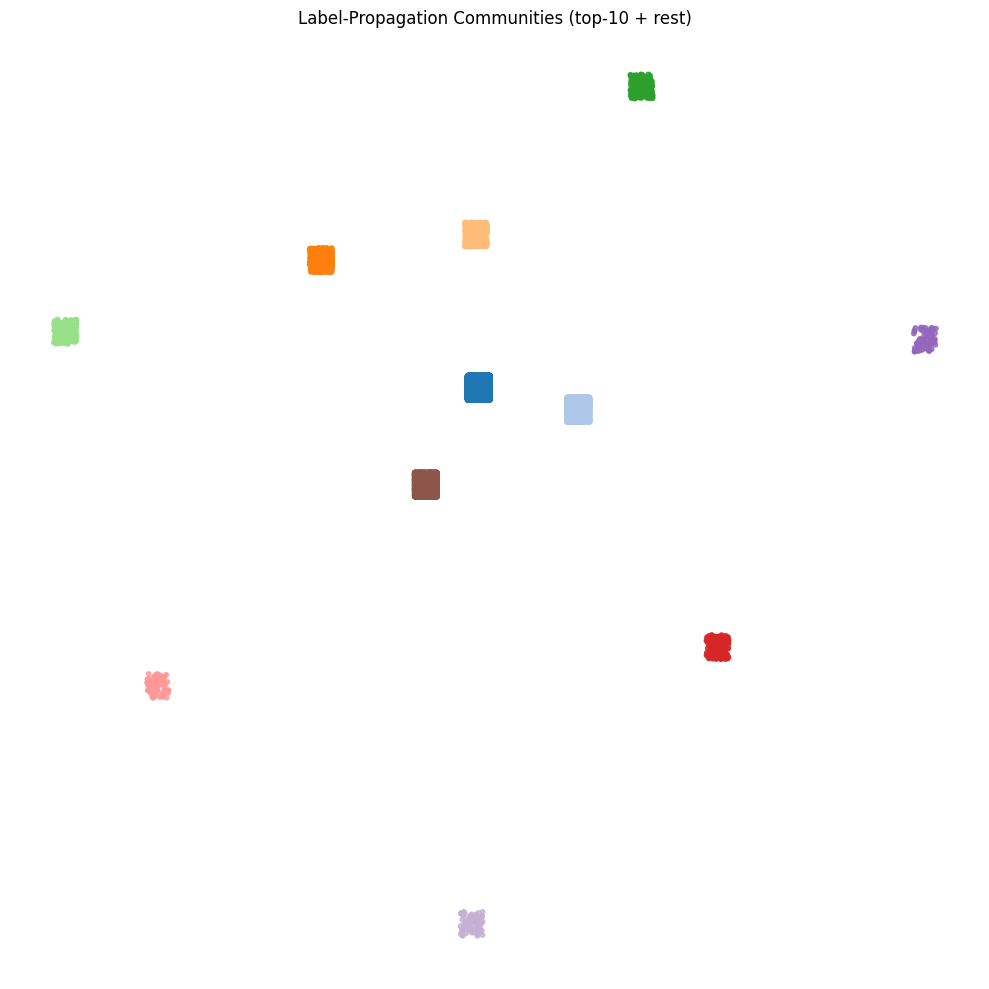

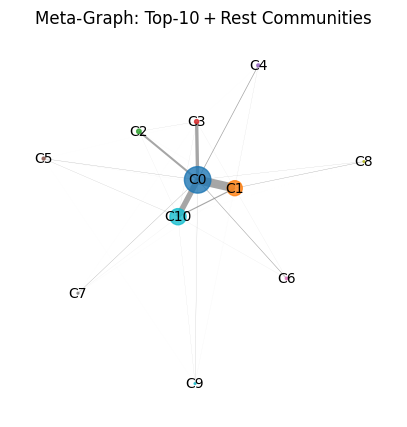

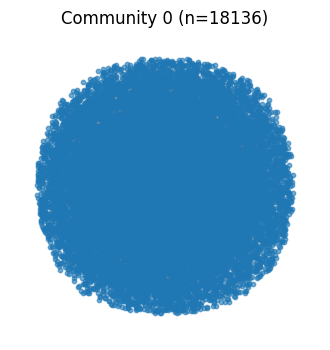

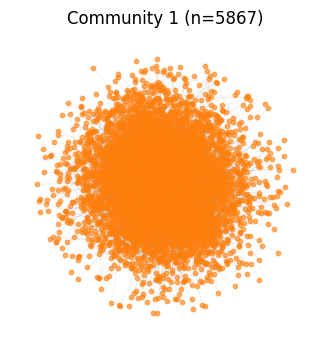

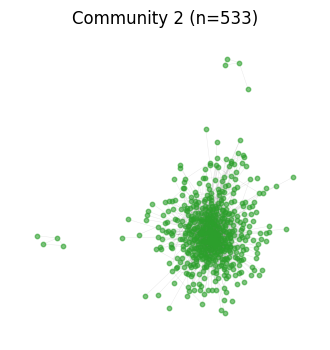

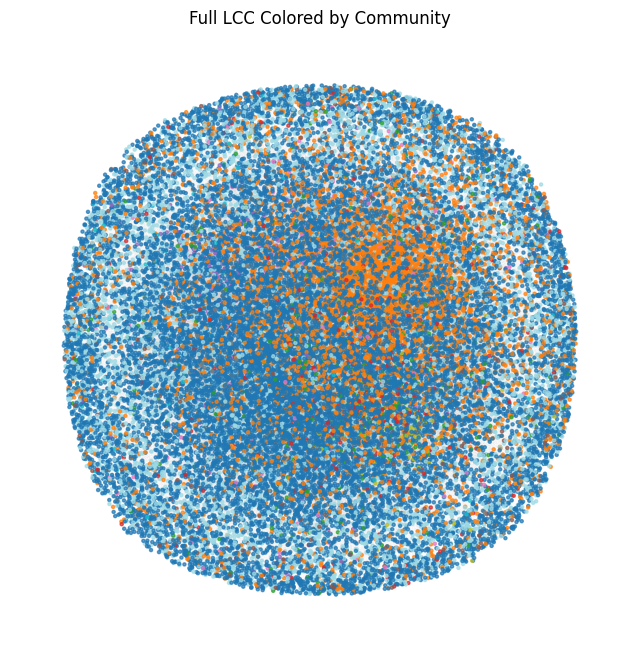

In [ ]:
# 1) Detect all communities
all_comms = list(label_propagation_communities(LCC))
print(f"Detected {len(all_comms)} communities")

# 2) Global modularity
print(f"Global modularity: {modularity(LCC, all_comms):.4f}")

# 3) Show top-10 by size & conductance
topK = sorted(all_comms, key=len, reverse=True)[:10]
print("Top 10 communities (size & phi):")
for i, comm in enumerate(topK):
    print(f"  C{i:2d} size={len(comm):5d}  phi={conductance(LCC,comm):.4f}")

# 4) Build node→community map (0…9 top, 10 = rest)
K = 10
rest_id = K
comm_of = {}
for idx, comm in enumerate(topK):
    for u in comm:
        comm_of[u] = idx
# any node not in topK goes to rest_id
for u in LCC:
    comm_of.setdefault(u, rest_id)

# 5) Count edges between communities
edge_counts = Counter()
for u, v in LCC.edges():
    cu, cv = comm_of[u], comm_of[v]
    if cu == cv:
        continue
    a, b = (cu, cv) if cu < cv else (cv, cu)
    edge_counts[(a, b)] += 1

# 6) Build the tiny community‐graph C with weights
C = nx.Graph()
C.add_nodes_from(range(K+1))
for (a, b), w in edge_counts.items():
    C.add_edge(a, b, weight=w)

# 7) Layout on C (11 nodes)
pos_c = nx.spring_layout(C, seed=42, k=1.0, iterations=100)

# 8) Jitter back to original nodes
pos = {}
for u in LCC:
    c = comm_of[u]
    cx, cy = pos_c[c]
    pos[u] = (cx + 0.05*(random.random()-0.5),
              cy + 0.05*(random.random()-0.5))

# 9) Draw just the nodes, colored by community
palette = plt.cm.tab20.colors
plt.figure(figsize=(10,10))
# a) draw all nodes
nx.draw_networkx_nodes(
    LCC, pos,
    node_size=10,
    node_color=[palette[comm_of[u] % len(palette)] for u in LCC],
    alpha=0.8
)

# b) overlay centroid squares + labels
for c, (cx, cy) in pos_c.items():
    plt.scatter(
        cx, cy,
        s=300,                               # size of the square
        c=[palette[c % len(palette)]],       # match community color
        marker='s',                          # square marker
        edgecolor='black', linewidth=1.0,    # outline for visibility
        zorder=3                             # draw on top of nodes
    )
    plt.text(
        cx, cy, f"C{c}",
        fontsize=12, fontweight='bold',
        ha='center', va='center',
        color='white',
        zorder=4
    )

plt.title("Label-Propagation Communities (top-10 + rest)")
plt.axis('off')
plt.tight_layout()
plt.show()
# 1) Meta-graph of communities alone
plt.figure(figsize=(5,5))
# draw community-graph C
# node size ∝ community size
comm_sizes = [len(topK[i]) if i < len(topK) else len(LCC)-sum(len(c) for c in topK)
              for i in C.nodes()]
# scale down so circles aren’t enormous
node_sizes = [s*0.02 for s in comm_sizes]

# edge width ∝ weight
edge_widths = [C[u][v]['weight']/1000 for u,v in C.edges()]

nx.draw_networkx_nodes(C, pos_c,
                       node_size=node_sizes,
                       node_color=list(C.nodes()),
                       cmap=plt.cm.tab10,
                       alpha=0.8)
nx.draw_networkx_edges(C, pos_c,
                       width=edge_widths,
                       edge_color='gray',
                       alpha=0.7)
nx.draw_networkx_labels(C, pos_c,
                       labels={i: f"C{i}" for i in C.nodes()},
                       font_size=10)
plt.title("Meta-Graph: Top-10 + Rest Communities")
plt.axis('off')
plt.show()


# 2) Zoom into individual top communities
for cid in range(3):       # change range(3) to whichever top-K you want
    members = topK[cid]
    sub = LCC.subgraph(members)
    pos_sub = nx.spring_layout(sub, seed=cid, k=0.1)

    plt.figure(figsize=(4,4))
    nx.draw_networkx_nodes(sub, pos_sub,
                           node_size=10,
                           node_color=f"C{cid}",
                           alpha=0.6)
    nx.draw_networkx_edges(sub, pos_sub,
                           width=0.3,
                           alpha=0.2,
                           edge_color='gray')
    plt.title(f"Community {cid} (n={len(sub)})")
    plt.axis('off')
    plt.show()


# 3) Full LCC overlay, colored by community
pos_full = nx.spring_layout(LCC, seed=42, k=0.1, iterations=50)

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(LCC, pos_full,
                       alpha=0.02,
                       edge_color='lightgray',
                       width=0.1)
nx.draw_networkx_nodes(LCC, pos_full,
                       node_size=5,
                       node_color=[comm_of[u] for u in LCC.nodes()],
                       cmap=plt.cm.tab20,
                       alpha=0.7)
plt.title("Full LCC Colored by Community")
plt.axis('off')
plt.show()


# ─── Part 8: Per-Community Stats ────

In [ ]:
# Pre-compute node-level clustering once
node_clust = nx.clustering(LCC)  # node → clustering coefficient

# Pick only the top K largest communities
K = 10
comm_sizes = sorted(
    [(i, len(c)) for i, c in enumerate(all_comms)],
    key=lambda x: x[1],
    reverse=True
)[:K]

# How many BFS sources per community
S = 20

stats = []
for idx, size in comm_sizes:
    comm = all_comms[idx]
    n = size

    # 1) avg local clustering
    avg_cl = sum(node_clust[u] for u in comm) / n

    # 2) induced subgraph
    sub = LCC.subgraph(comm).copy()

    # 3) diameter (two‐sweep) on the connected piece
    if nx.is_connected(sub):
        diam = approx.diameter(sub, seed=42)
        target = sub
    else:
        # fall back to largest connected component
        comps = list(nx.connected_components(sub))
        lcc_sub = sub.subgraph(max(comps, key=len)).copy()
        diam = approx.diameter(lcc_sub, seed=42)
        target = lcc_sub

    # 4) approx avg path length by sampling S nodes
    members = list(target.nodes())
    sample_nodes = random.sample(members, min(len(members), S))
    total_d, total_pairs = 0, 0
    for u in sample_nodes:
        lengths = nx.single_source_shortest_path_length(target, u)
        total_d    += sum(lengths.values())
        total_pairs += (len(lengths) - 1)
    avg_pl = total_d / total_pairs

    stats.append({
        'community':       idx,
        'n_nodes':         n,
        'avg_clustering':  avg_cl,
        'diameter':        diam,
        'avg_path_length': avg_pl
    })

# Build DataFrame and display
df_stats = pd.DataFrame(stats,
    columns=['community','n_nodes','avg_clustering','diameter','avg_path_length']
).sort_values('n_nodes', ascending=False)

print("\nPart 8: Top 10 Community Metrics")
print(df_stats.to_string(index=False))


Part 8: Top 10 Community Metrics
 community  n_nodes  avg_clustering  diameter  avg_path_length
         2    18136        0.098772        10         4.049460
         7     5867        0.121252         8         3.342184
        19      533        0.183168         6         2.921756
        13      448        0.226172         6         2.892282
        12      248        0.300080         5         2.524089
        14      227        0.067560         7         2.417699
        16      180        0.305536         6         2.275714
        36       87        0.315547         4         1.798980
        35       83        0.441633         5         2.190244
         9       77        0.211391         4         2.364474


# ─── Part 9: Centrality-scaled Visualization & Gephi Export ───

In [ ]:
# — assume LCC is your undirected largest connected component —

communities = list(label_propagation_communities(LCC))
print(f"Detected {len(communities)} communities")

# 2) Compute degree centrality
deg_cent = nx.degree_centrality(LCC)

# 3) Build node->community map
comm_of = {u: idx
           for idx, comm in enumerate(communities)
           for u in comm}

# 4) Export for Gephi
nx.set_node_attributes(LCC, comm_of, 'community')
nx.set_node_attributes(LCC, deg_cent, 'degree_centrality')
nx.write_gexf(LCC, 'twitter_lcc_comm.gexf')
print("Exported GEXF to twitter_lcc_comm.gexf for Gephi")

# 5) Decide how many top communities to highlight
TOP_K = 10

# 6) Prepare a color index for each node:
#    0..TOP_K-1 for the largest TOP_K communities, TOP_K for all others
#    First find the sizes:
sizes = sorted([(i, len(c)) for i, c in enumerate(communities)],
               key=lambda x: x[1], reverse=True)
top_ids = {i for i, _ in sizes[:TOP_K]}
node_colors = []
for u in LCC:
    cid = comm_of.get(u, TOP_K)
    node_colors.append(cid if cid in top_ids else TOP_K)

# 7) Compute spring layout once
pos = nx.spring_layout(LCC, seed=42, k=0.1, iterations=30)

# 8) Draw
plt.figure(figsize=(12,12))
ax = plt.gca()
ax.set_facecolor('white')

# 8a) edges: very faint
nx.draw_networkx_edges(
    LCC, pos,
    alpha=0.02,
    edge_color='lightgray',
    width=0.1,
    ax=ax
)

# 8b) nodes: size ∝ degree centrality, color = community index
node_sizes = [2000 * deg_cent[u] for u in LCC]  # adjust multiplier as needed
nodes = nx.draw_networkx_nodes(
    LCC, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.8,
    linewidths=0
)

plt.title("Twitter LCC: size ∝ degree, color = top communities")
plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'label_propagation_communities' is not defined

# ─── Part 10: Erdos Number ───

In [ ]:
# 1) Raw degree
deg_raw = dict(LCC.degree())

# 2) Compute “Erdos score” = degree + sum of neighbor degrees
erdos_score = {
    u: deg_raw[u] + sum(deg_raw[v] for v in LCC.neighbors(u))
    for u in LCC
}

# 3) Find the “Erdos node”
erdos_node = max(erdos_score, key=erdos_score.get)
print(f"Erdos node: {erdos_node}, score = {erdos_score[erdos_node]}")

# 4) Compute each node’s distance from Erdos node
dist = nx.single_source_shortest_path_length(LCC, erdos_node)

# 5) Plot the histogram of Erdos‐numbers
plt.figure(figsize=(8,5))
bins = range(max(dist.values())+2)
plt.hist(dist.values(), bins=bins, edgecolor='black', align='left')
plt.xlabel('Erdos number (graph distance from node {})'.format(erdos_node))
plt.ylabel('Count of nodes')
plt.title('Distribution of Modified Erdos Numbers')
plt.xticks(bins)
plt.tight_layout()
plt.show()

NameError: name 'LCC' is not defined

# ─── End ───